In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re

import acquire
import prepare

#ignore minor warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_in = acquire.get_data(query_url = False)
print(df_in.shape)
df_in = prepare.prepare_dataframe(df_in)
train, validate, test = prepare.split_data(df_in)
train.shape, validate.shape, test.shape

Found file in working directory!
(70932, 83)


((53199, 63), (26599, 63), (26600, 63))

# Question 1: What effect does release date have on the price?

## Key takeaway
- 1993, 1994 and 1999 have a higher than average price for cards released in those years.

## Discusion
In charting the usd price as a line graph, it appears that there are spikes in the price in the '90s, and possible in the '20s. In charting mean price per year in a 

## Visualization

It looks like the mid '90s, just before '00, and post-'20 might have higher prices

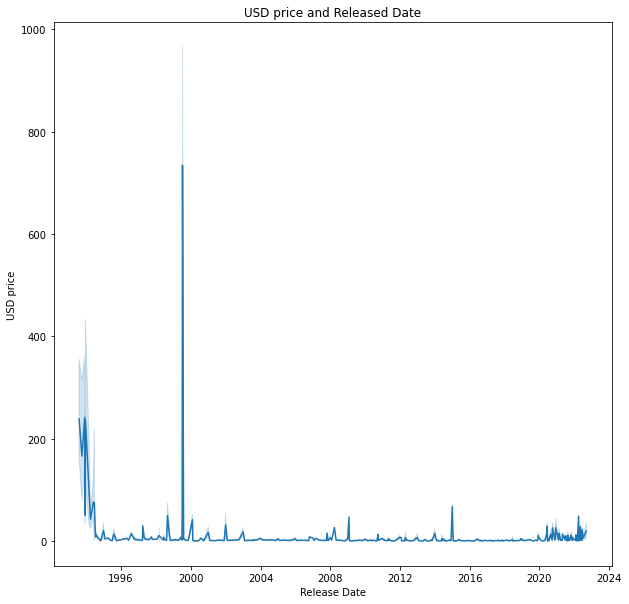

In [3]:
def vis_usd_by_released_at(df):
    plt.figure(figsize=(10,10))
    sns.lineplot(data=df[df['usd'] > 0], x='released_at', y='usd')
    plt.title('USD price and Released Date')
    plt.xlabel('Release Date')
    plt.ylabel('USD price')
    plt.show()

vis_usd_by_released_at(train)

Looks like '93 and '94 have the highest average price, followed by '98 and '99. The spikes in the line graph are not effecting the average price in the year.

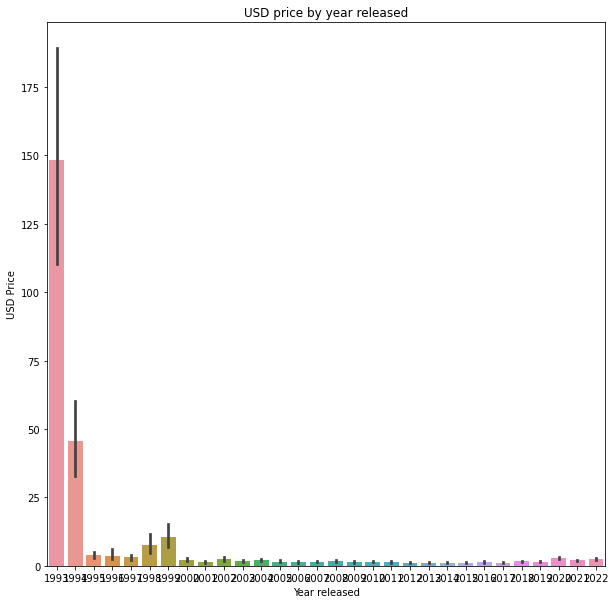

In [4]:
def make_year_released_column(df):
    df['year_released'] = df['released_at'].dt.year
    return df

def vis_usd_by_year(df):
    df = make_year_released_column(df)
    plt.figure(figsize=(10,10))
    sns.barplot(data=df[df['usd'] > 0], x='year_released', y='usd')
    plt.title('USD price by year released')
    plt.xlabel('Year released')
    plt.ylabel('USD Price')
    plt.show()
    
vis_usd_by_year(train)

## Hypothesis Testing

$H_0$ Year $x$ has a average price per card equal to or less than the general average price.

$H_a$ Year $x$ has a average price per card greater than the general average price.

In [5]:
def hypothesis_test_years(df, alpha = 0.05):
    years_to_test = df['year_released'].unique().tolist()
    outputs = []
    for year in years_to_test:
        in_year_sample = df[(df['year_released'] == year) & (df['usd'] > 0)]['usd']
        overall_mean = df['usd'].mean()
        t, p = stats.ttest_1samp(in_year_sample, overall_mean)
        output = {
            'year':year,
            'year_mean':in_year_sample.mean(),
            't_stat':t,
            'p_value':p,
            'reject_null': t > 0 and p/2 < alpha
        }
        outputs.append(output)
    return pd.DataFrame(outputs)

hypothesis_test_years(train).sort_values('reject_null', ascending = False).head(5)

,year,year_mean,t_stat,p_value,reject_null
20,1993,148.193250,7.265409,7.453173e-13,True
17,1999,10.401635,2.415763,1.585666e-02,True
16,1994,45.440055,5.722270,1.426604e-08,True
0,2010,1.531173,-23.241438,5.602461e-97,False
1,2020,2.868817,-12.660381,6.998747e-36,False


The null is likely wrong for '93, '99 and '94.  These years have a higher than average price for their cards.

# Question 2: What effect does basic card type have on price?

## Key takeaway
- Land, artifacts, enchantment and legendary are priced higher than other cards

## Discusion
Land, artifact, enchantment and legendary cards have a statistically higher price than other cards. Some further questions to be asked is if these card types have more rares or particular artists.  In addition, it might be worth looking at subsets of some of these.

## Visualization

Definitely looks like the card type has an effect.

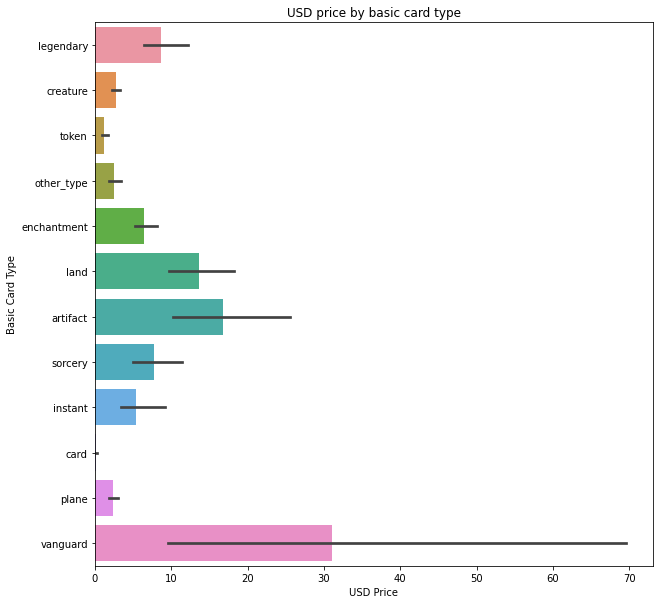

In [14]:
def make_card_type_column(df):
    card_cats = ['Card', 'Vanguard', 'Plane', 'Creature', 'Land', 'Enchantment', 'Artifact', 'Sorcery', 'Instant', 'Legendary', 'Token']
    df['card_type'] = 'other_type'
    for card_cat in card_cats:
        df.loc[df['type_line'].str.contains(card_cat).fillna(False), 'card_type'] = card_cat.lower()
    df.loc[df['type_line'].str.contains('Card // Card').fillna(False), 'card_type'] = 'split_card'
    return df

def vis_by_card_type(df):
    df = make_card_type_column(df)
    plt.figure(figsize=(10,10))
    sns.barplot(data=df[df['usd'] > 0], y='card_type', x='usd')
    plt.title('USD price by basic card type')
    plt.xlabel('USD Price')
    plt.ylabel('Basic Card Type')
    plt.show()
    
vis_by_card_type(train)

In [7]:
make_card_type_column(train).groupby('card_type').usd.describe()

,count,mean,std,min,25%,50%,75%,max
card_type,,,,,,,,
artifact,4864.0,13.292338,214.181870,0.0,0.0300,0.200,1.0500,11500.00
card,165.0,0.022061,0.074502,0.0,0.0000,0.000,0.0000,0.65
creature,18657.0,2.202774,27.234430,0.0,0.0200,0.110,0.2600,2499.94
enchantment,5004.0,5.240284,42.722704,0.0,0.0500,0.190,1.1025,1500.73
instant,5992.0,4.438805,94.179565,0.0,0.0300,0.120,0.3500,6999.99
land,5554.0,10.086541,129.107937,0.0,0.0000,0.190,0.6400,6000.00
legendary,4920.0,4.974333,59.747832,0.0,0.0000,0.190,2.1800,3888.00
other_type,204.0,2.008971,4.483442,0.0,0.1075,0.415,1.7325,38.14
plane,123.0,2.232439,3.169852,0.0,1.3000,1.620,2.4300,32.77


## Hypothesis Testing

$H_0$ : Mean price for card type $x$ is less than or equal to the overall mean price.

$H_a$ : Mean price for card type $x$ is greater than the overall mean price.

In [12]:
def hypothesis_test_card_type(df, alpha = 0.05):
    card_types_to_test = df['card_type'].unique().tolist()
    outputs = []
    for card_type in card_types_to_test:
        in_card_sample = df[(df['card_type'] == card_type) & (df.usd > 0.01)]['usd']
        overall_mean = df['usd'].mean()
        t, p = stats.ttest_1samp(in_card_sample, overall_mean)
        output = {
            'card_type':card_type,
            'card_type_mean':in_card_sample.mean(),
            't_stat':t,
            'p_value':p,
            'reject_null': t > 0 and p/2 < alpha
        }
        outputs.append(output)
    return pd.DataFrame(outputs)

hypothesis_test_card_type(train).sort_values('reject_null', ascending = False)

,card_type,card_type_mean,t_stat,p_value,reject_null
0,legendary,8.672466,2.345265,1.908249e-02,True
4,enchantment,6.562020,1.806539,7.090948e-02,True
5,land,13.600546,3.600642,3.211743e-04,True
6,artifact,17.108576,3.014718,2.589283e-03,True
1,creature,2.843890,-9.153588,6.233671e-20,False
2,token,1.223322,-19.127625,6.303734e-64,False
3,other_type,2.483818,-7.163127,2.530195e-11,False
7,sorcery,7.907063,1.624765,1.042830e-01,False
8,instant,5.558207,0.236287,8.132202e-01,False
9,split_card,NaN,NaN,NaN,False


# Question 3

## Key takeaway
- key takeaway 1

## Discusion
At least 3 sentences explanation

## Visualization

In [9]:
#functions go here

## Hypothesis Testing

In [17]:
#functions go here
train.frame.value_counts()

2015      28993
2003      12720
1997       7244
1993       4179
future       63
Name: frame, dtype: int64

In [ ]:
train.